In [10]:
import camb
import numpy as np
from scipy.integrate import quad
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

In [11]:
# Functions

def P_L(H0=67.5, ombh2=0.022, omch2=0.12, omk=0, TCMB=2.725, w=-1, z=[0]):
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=H0, ombh2=ombh2, omch2=omch2, TCMB=TCMB, omk=omk)
    pars.set_dark_energy(w=w)
    pars.InitPower.set_params(As=2e-9, ns=0.965, r=0)
    pars.set_matter_power(redshifts=z, kmax=5.0)
    results = camb.get_results(pars)
    kh, z, pk = results.get_matter_power_spectrum(minkh=2e-5, maxkh=5.0, npoints=200)
    return kh, pk[0]

def H(a, Omega_m=0.3116, Omega_DE=0.6883, H0=67.5):
    H = H0 * np.sqrt(Omega_m * a**(-3) + Omega_DE + (1 - Omega_m - Omega_DE) * a**(-2))
    return H

def D(z, Omega_m=0.3116, Omega_DE=0.6883, H0=67.5):
    a = 1 / (1 + z)
    prod = (5/2) * Omega_m * (H(a, Omega_m, Omega_DE, H0) / H0)
    def integrand(a_prime):
        integrand = 1 / (a_prime * H(a_prime, Omega_m, Omega_DE, H0) / H0)**3
        return integrand
    integral, _ = quad(integrand, 0, a)
    result = prod * integral
    return result

def W(k, R):
    W_func = 3 * (np.sin(k * R) / (k * R) - np.cos(k * R)) / (k * R)**2
    return W_func

def sigma(R, z=0):
    kh, pk = P_L(z=[z])
    pk_interpolated = interp1d(kh, pk, kind='linear')
    def integrand(k):
        Wk = W(k, R)
        return k**2 * pk_interpolated(k) * Wk**2 / (2 * np.pi ** 2)
    sigma_squared = quad(integrand, min(kh), max(kh))[0]
    sigma_value = D(z) * np.sqrt(sigma_squared)
    return sigma_value

def mass_to_radius(M, rho_m0=2.775e11):
    return (3 * M / (4 * np.pi * rho_m0)) ** (1/3)

def f_sigma(sigma, A=0.186, a=1.47, b=2.57, c=1.19):
    f_s = A * ( ( sigma / b ) ** (-a) + 1 ) * np.exp( - c / sigma ** 2 )
    return f_s

def dn_dM(M_values, sigma_M, d_ln_sigma_inv_d_ln_M, Omega_m=0.3116, rho_m0=2.775e11):
    rho_m = rho_m0 * Omega_m
    f_s = f_sigma(sigma_M)
    dn_dM = f_s * rho_m * d_ln_sigma_inv_d_ln_M / M_values
    return dn_dM

def n_z(dn_dM, M_values, M_min=1e14):
    dn_dM_interp = interp1d(np.log(M_values), dn_dM, kind='linear', bounds_error=False, fill_value=0)
    integrand = lambda lnM: dn_dM_interp(lnM)
    result, _ = quad(integrand, np.log(M_min), np.log(M_values[-1]))
    return result

def D_A(z, Omega_m=0.3116, Omega_DE=0.6883, H0=67.5):
    a = 1 / (1 + z)
    def integrand(a_prime):
        return 1 / (H(a_prime, Omega_m, Omega_DE, H0) / H0 * a_prime ** 2)
    integral, _ = quad(integrand, a, 1)
    return integral

def n_zi(z_values, n_values, z_bins, Delta_Omega_deg2=5000, H0=67.5, Omega_m=0.3116, Omega_DE=0.6883):
    Delta_Omega = np.deg2rad(np.sqrt(Delta_Omega_deg2))**2
    z_bin_centers = (z_bins[:-1] + z_bins[1:]) / 2
    N_values = []
    n_z_interp = interp1d(z_values, n_values, kind='linear')

    for i in range(len(z_bins) - 1):
        z_i = z_bins[i]
        z_f = z_bins[i + 1]

        def integrand(z):
            D_z = D_A(z)
            Hz = H(1 / (1 + z), Omega_m, Omega_DE, H0)
            return n_z_interp(z) * D_z**2 / Hz

        N_z_bin, _ = quad(integrand, z_i, z_f)
        N_z_bin *= Delta_Omega
        N_values.append(N_z_bin)

    return z_bin_centers, N_values

In [12]:
M_values = np.logspace(12, 16, 100)  # Mass range in Msun/h
sigma_M_z0 = np.zeros(len(M_values))

for i, M in enumerate(M_values):
    R = mass_to_radius(M)
    sigma_M_z0[i] = sigma(R, z=0)
sigma_M_z1 = sigma_M_z0 * D(1) / D(0)

/tmp/ipykernel_30621/2518729814.py:37: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  sigma_squared = quad(integrand, min(kh), max(kh))[0]


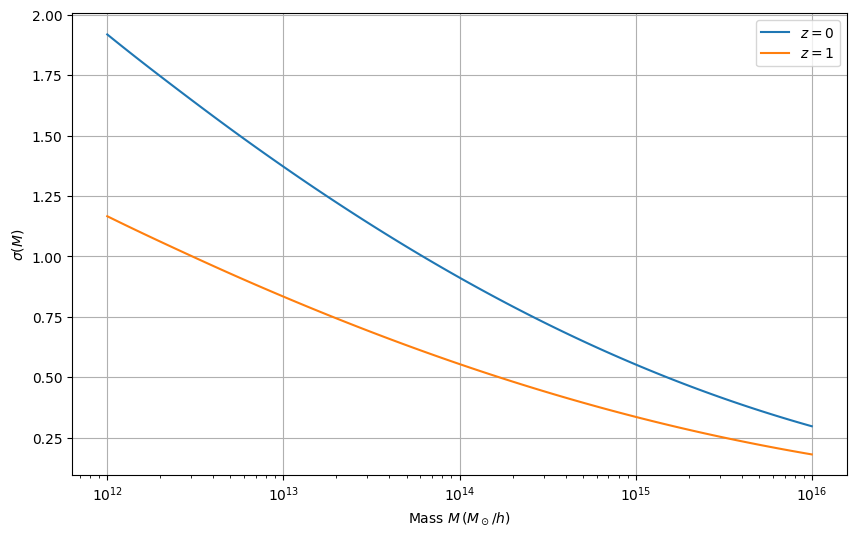

In [13]:
# Plot sigma(M) vs. M
plt.figure(figsize=(10, 6))
plt.semilogx(M_values, sigma_M_z0, label=r'$z=0$')
plt.semilogx(M_values, sigma_M_z1, label=r'$z=1$')
plt.xlabel(r'Mass $M \, (M_\odot/h)$')
plt.ylabel(r'$\sigma(M)$')
plt.legend()
plt.grid(True)
plt.savefig('item_a.png', dpi=240)
plt.show()

In [14]:
# Find the mass M where sigma(M) = delta_c
from scipy.interpolate import interp1d
sigma_interp = interp1d(sigma_M_z0, M_values)
M_critical = sigma_interp(1.686)
print(f"Mass M where sigma(M) = delta_c: {M_critical:.2e} Msun/h")

Mass M where sigma(M) = delta_c: 2.57e+12 Msun/h


In [15]:
# Plot dln(sigma -1)/dlnM vs. M
d_ln_sigma_inv_d_ln_M_z0 = - M_values * np.gradient(sigma_M_z0, M_values) / sigma_M_z0
d_ln_sigma_inv_d_ln_M_z1 = - M_values * np.gradient(sigma_M_z1, M_values) / sigma_M_z1

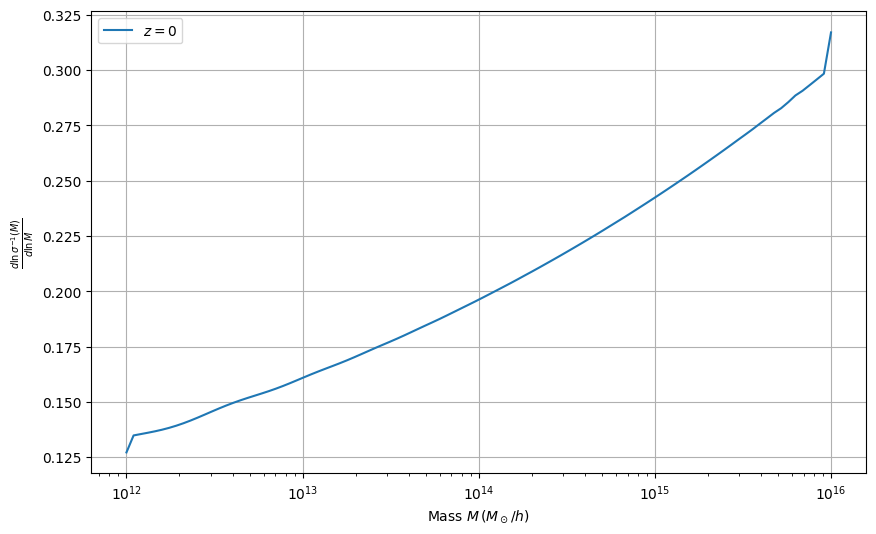

In [16]:
plt.figure(figsize=(10, 6))
plt.semilogx(M_values, d_ln_sigma_inv_d_ln_M_z0, label=r'$z=0$')
plt.xlabel(r'Mass $M \, (M_\odot/h)$')
plt.ylabel(r'$\frac{d\ln\sigma^{-1}(M)}{d\ln M}$')
plt.legend()
plt.grid(True)
plt.savefig('item_b.png', dpi=240)
plt.show()

In [17]:
# Halo mass function plot
dn_dM_z0 = dn_dM(M_values, sigma_M_z0, d_ln_sigma_inv_d_ln_M_z0)
dn_dM_z1 = dn_dM(M_values, sigma_M_z1, d_ln_sigma_inv_d_ln_M_z1)

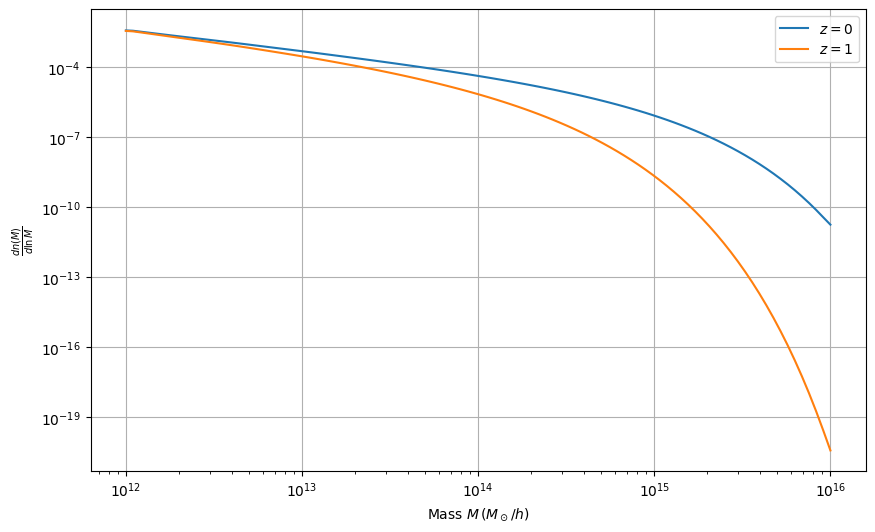

In [18]:
plt.figure(figsize=(10, 6))
plt.loglog(M_values, dn_dM_z0, label=r'$z=0$')
plt.loglog(M_values, dn_dM_z1, label=r'$z=1$')
plt.xlabel(r'Mass $M \, (M_\odot/h)$')
plt.ylabel(r'$\frac{d n(M)}{d\ln M}$')
plt.legend()
plt.grid(True)
plt.savefig('item_c.png', dpi=240)
plt.show()

In [19]:
z_values = np.linspace(0, 2, 100)
n_values = np.zeros(len(z_values))

for i, z in enumerate(z_values):
    sigma_M_z = sigma_M_z0 * D(z) / D(0)
    
    d_ln_sigma_inv_d_ln_M_z = - M_values * np.gradient(sigma_M_z, M_values) / sigma_M_z
    dn_dM_z = dn_dM(M_values, sigma_M_z, d_ln_sigma_inv_d_ln_M_z)
    
    n_z_value = n_z(dn_dM_z, M_values)
    n_values[i] = n_z_value

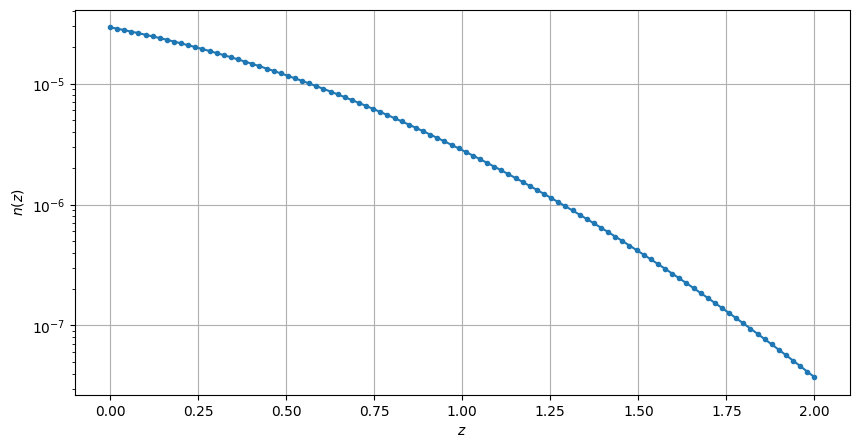

In [20]:
plt.figure(figsize=(10, 5))
plt.semilogy(z_values, n_values, marker='o', markersize=3)
plt.xlabel(r'$z$')
plt.ylabel(r'$n(z)$')
plt.grid(True)
plt.savefig('item_d.png', dpi=240)
plt.show()

In [21]:
z_bins = np.linspace(0, 2, 21)
z_bin_centers, N_values = n_zi(z_values, n_values, z_bins)

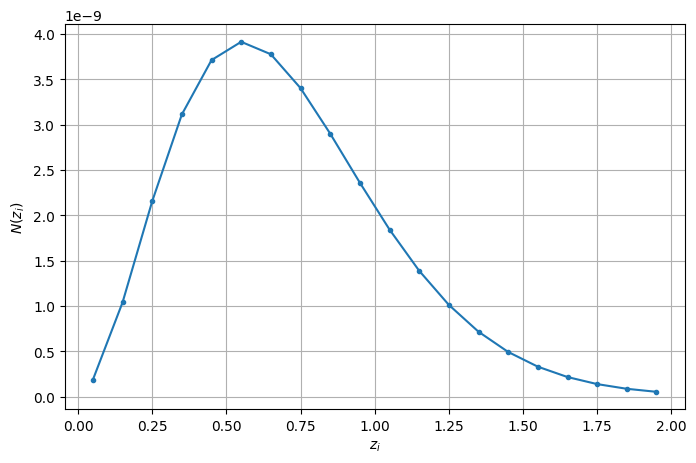

In [22]:
# Plot N(z_i) vs. z_i
plt.figure(figsize=(8, 5))
plt.plot(z_bin_centers, N_values, marker='o', markersize=3)
plt.xlabel(r'$z_i$')
plt.ylabel(r'$N(z_i)$')
plt.grid(True)
plt.savefig('item_e.png', dpi=240)
plt.show()